In [1]:
import os
import re

# ------------------------------
# 来自新的 .sh 的有效参数空间
# ------------------------------
VALID_RATIO_DYN = {
    "0.00", "0.0001", "0.001", "0.01", "0.02", "0.04",
    "0.08", "0.16", "0.32", "0.64", "0.80", "0.99", "1.00"
}
VALID_N = {4, 8, 16, 32, 64, 128, 256, 512}
VALID_H = {10, 13}
VALID_TP = {1, 2, 4, 9}

# -------------------------------------------------
# 新文件名格式：ratioXXX_tXX_vXX_hXX_tpXX.log
# -------------------------------------------------
def parse_filename_params(filename):
    reg = re.compile(
        r"ratio(?P<ratio>[0-9.]+)"
        r"_t(?P<t>[0-9]+)"
        r"_v(?P<v>[0-9]+)"
        r"_h(?P<h>[0-9]+)"
        r"_tp(?P<tp>[0-9]+)\.log"
    )
    m = reg.search(filename)
    if not m:
        return None

    ratio = m.group("ratio")
    t = int(m.group("t"))
    v = int(m.group("v"))
    h = int(m.group("h"))
    tp = int(m.group("tp"))

    return ratio, t, v, h, tp


def check_from_sh(ratio, t, v, h, tp):
    """判断是否来自 .sh 的遍历"""
    if ratio not in VALID_RATIO_DYN:
        return False
    if t not in VALID_N:
        return False
    if v not in VALID_N:
        return False
    if h not in VALID_H:
        return False
    if tp not in VALID_TP:
        return False
    return True


# -------------------------------------------------
# 解析日志内容：max_valid_acc / min_valid_loss / 4 个比例
# -------------------------------------------------
def parse_log_file(path, filename):
    max_valid_acc = None
    min_valid_loss = None

    pct00 = pct01 = pct10 = pct11 = None

    reg_valid_loss = re.compile(r"valid loss:\s*([0-9.]+)")
    reg_valid_acc  = re.compile(r"valid acc:\s*([0-9.]+)")
    reg_pct_row = re.compile(
        r"\|\s*(现在对了|现在错了)\s*\|\s*([0-9.]+)%\s*\|\s*([0-9.]+)%\s*\|"
    )

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            m = reg_valid_loss.search(line)
            if m:
                v = float(m.group(1))
                if min_valid_loss is None or v < min_valid_loss:
                    min_valid_loss = v

            m = reg_valid_acc.search(line)
            if m:
                v = float(m.group(1))
                if max_valid_acc is None or v > max_valid_acc:
                    max_valid_acc = v

            m = reg_pct_row.search(line)
            if m:
                typ = m.group(1)
                v1 = float(m.group(2))
                v2 = float(m.group(3))
                if typ == "现在对了":
                    pct00 = v1
                    pct01 = v2
                else:
                    pct10 = v1
                    pct11 = v2

    # 文件名参数
    parsed = parse_filename_params(filename)
    if parsed is None:
        ratio = t = v = h = tp = None
        valid = False
    else:
        ratio, t, vv, h, tp = parsed
        valid = check_from_sh(ratio, t, vv, h, tp)

    return {
        "file": filename,
        "ratio_dyn": ratio,
        "N_dynbr": t,
        "N_dynbr_v": vv,
        "h": h,
        "tp": tp,
        "valid_from_sh": valid,
        "max_valid_acc": max_valid_acc,
        "min_valid_loss": min_valid_loss,
        "pct_now_correct_old_correct": pct00,
        "pct_now_correct_old_wrong": pct01,
        "pct_now_wrong_old_correct": pct10,
        "pct_now_wrong_old_wrong": pct11,
    }


# -------------------------------------------------
# 遍历所有日志
# -------------------------------------------------
def collect_all_logs(root="."):
    results = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if fn.endswith(".log"):
                full = os.path.join(dirpath, fn)
                res = parse_log_file(full, fn)
                results.append(res)
    return results


# 主入口
logs = collect_all_logs(".")
print("解析日志数量:", len(logs))
logs[:5]


解析日志数量: 8433


[{'file': 'ratio0.64_t128_v128_h13_tp9.log',
  'ratio_dyn': '0.64',
  'N_dynbr': 128,
  'N_dynbr_v': 128,
  'h': 13,
  'tp': 9,
  'valid_from_sh': True,
  'max_valid_acc': 0.4731,
  'min_valid_loss': 2.50759,
  'pct_now_correct_old_correct': 41.5,
  'pct_now_correct_old_wrong': 4.74,
  'pct_now_wrong_old_correct': 16.36,
  'pct_now_wrong_old_wrong': 37.4},
 {'file': 'ratio0.32_t128_v16_h10_tp1.log',
  'ratio_dyn': '0.32',
  'N_dynbr': 128,
  'N_dynbr_v': 16,
  'h': 10,
  'tp': 1,
  'valid_from_sh': True,
  'max_valid_acc': 0.3154,
  'min_valid_loss': 6.185702,
  'pct_now_correct_old_correct': 29.44,
  'pct_now_correct_old_wrong': 1.37,
  'pct_now_wrong_old_correct': 28.42,
  'pct_now_wrong_old_wrong': 40.77},
 {'file': 'ratio0.80_t512_v128_h7_tp1.log',
  'ratio_dyn': '0.80',
  'N_dynbr': 512,
  'N_dynbr_v': 128,
  'h': 7,
  'tp': 1,
  'valid_from_sh': False,
  'max_valid_acc': 0.1045,
  'min_valid_loss': 7.956058,
  'pct_now_correct_old_correct': 9.23,
  'pct_now_correct_old_wrong': 0.

Total entries: 78

h=10, tp= 1, ratio=    0.00  max_acc=0.371600, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=  0.0001  max_acc=0.371600, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=   0.001  max_acc=0.371600, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=    0.01  max_acc=0.371100, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=    0.02  max_acc=0.373000, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=    0.04  max_acc=0.373000, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=    0.08  max_acc=0.372100, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=    0.16  max_acc=0.371100, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=    0.32  max_acc=0.370100, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=    0.64  max_acc=0.371600, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=    0.80  max_acc=0.360800, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=    0.99  max_acc=0.296900, N_dynbr=256, N_dynbr_v=4
h=10, tp= 1, ratio=    1.00  max_acc=0.020500, N_dynbr=256, N_dynbr_v=512
h=10, tp= 4, ratio=    0.00  max_acc=0.4819

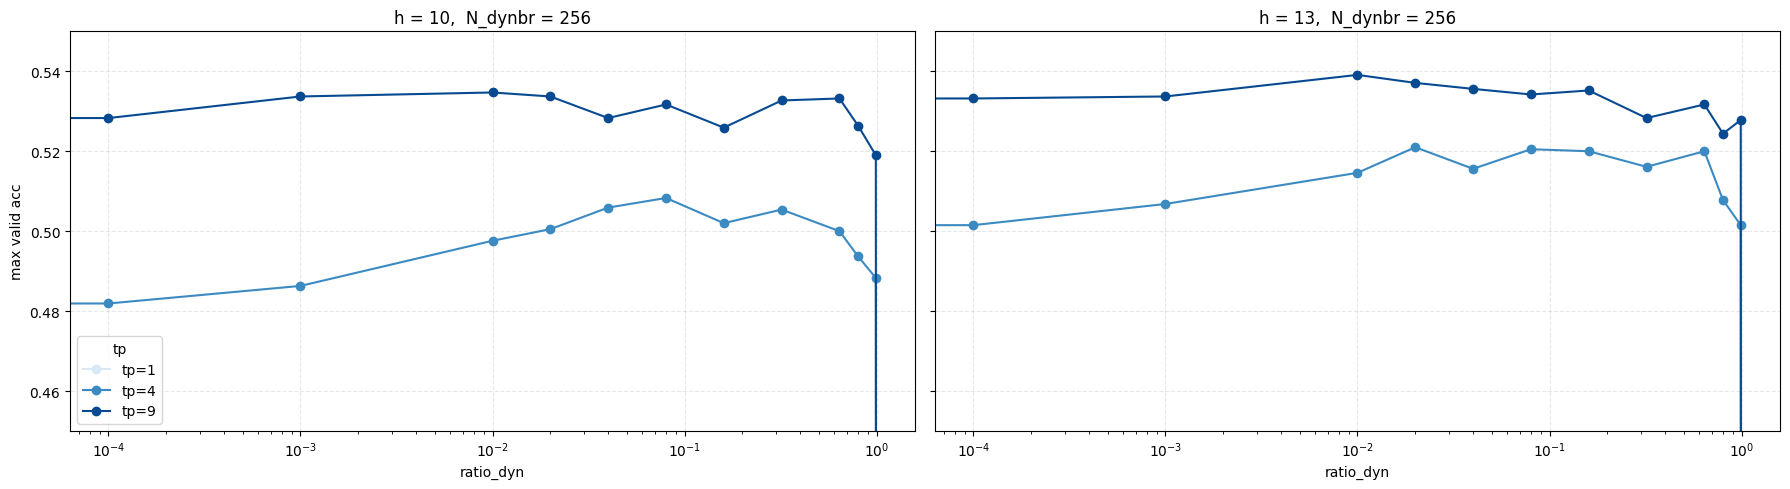

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# ============================================================
# 固定 N_dynbr
# ============================================================
N_fix = 256      # ★★★ 你可以改这里 ★★★

# ----------------------------------------------------
# 追加：记录 max valid acc 的来源 (N_dynbr_v)
# ----------------------------------------------------

# max_source[(h, tp, ratio)] = {
#     "max_acc": float,
#     "N_dynbr": int,
#     "N_dynbr_v": int
# }
max_source = {}

for item in logs:
    # 必须来自当前这份 .sh 生成的日志
    if not item["valid_from_sh"]:
        continue

    # ★★ 必须满足固定 N_dynbr
    if item["N_dynbr"] != N_fix:
        continue

    acc = item["max_valid_acc"]
    if acc is None:
        continue

    h = item["h"]
    tp = item["tp"]
    r = item["ratio_dyn"]
    v = item["N_dynbr_v"]

    key = (h, tp, r)

    if key not in max_source:
        max_source[key] = {
            "max_acc": acc,
            "N_dynbr": N_fix,
            "N_dynbr_v": v
        }
    else:
        if acc > max_source[key]["max_acc"]:
            max_source[key] = {
                "max_acc": acc,
                "N_dynbr": N_fix,
                "N_dynbr_v": v
            }

# ----------------------------------------------------
# 按 (h, tp, ratio_dyn) 排序输出 max_source
# ----------------------------------------------------

sorted_keys = sorted(
    max_source.keys(),
    key=lambda x: (x[0], x[1], float(x[2]))   # (h, tp, ratio_dyn_float)
)

print("Total entries:", len(sorted_keys))
print("")

for key in sorted_keys:
    h, tp, ratio = key
    info = max_source[key]
    print(
        f"h={h:2d}, tp={tp:2d}, ratio={ratio:>8}  "
        f"max_acc={info['max_acc']:.6f}, "
        f"N_dynbr={info['N_dynbr']}, "
        f"N_dynbr_v={info['N_dynbr_v']}"
    )

# ----------------------------------------------------
# 聚合 (h, tp, ratio_dyn) → max valid acc
#      也必须依赖固定 N_dynbr = N_fix
# ----------------------------------------------------

acc_map = defaultdict(lambda: defaultdict(dict))
# acc_map[h][tp][ratio] = max acc

for item in logs:
    if not item["valid_from_sh"]:
        continue

    # ★★ 固定 N_dynbr
    if item["N_dynbr"] != N_fix:
        continue

    acc = item["max_valid_acc"]
    if acc is None:
        continue

    h = item["h"]
    tp = item["tp"]
    r = item["ratio_dyn"]

    if r not in acc_map[h][tp]:
        acc_map[h][tp][r] = acc
    else:
        acc_map[h][tp][r] = max(acc_map[h][tp][r], acc)

# ----------------------------------------------------
# 排序参数
# ----------------------------------------------------
all_h = sorted(acc_map.keys())
tp_list = sorted({tp for h in acc_map for tp in acc_map[h]})
ratio_list_all = sorted(
    {r for h in acc_map for tp in acc_map[h] for r in acc_map[h][tp]},
    key=float
)

# ----------------------------------------------------
# 颜色设定：Blues_r 的 {0.1, 0.35, 0.6, 0.85}
# ----------------------------------------------------
cmap = plt.get_cmap("Blues_r")
tp_colors = {
    9: cmap(0.10),
    4: cmap(0.35),
    2: cmap(0.60),
    1: cmap(0.85)
}

# ----------------------------------------------------
# 统一 Y 轴范围
# ----------------------------------------------------
all_acc_values = []
for h in acc_map:
    for tp in acc_map[h]:
        all_acc_values += list(acc_map[h][tp].values())

if len(all_acc_values) > 0:
    y_min = min(all_acc_values)
    y_max = max(all_acc_values)
else:
    y_min, y_max = 0, 1  # fallback

# ----------------------------------------------------
# 绘图：1 行 2 列（因为你有两个 h）
# ----------------------------------------------------
fig, axes = plt.subplots(1, len(all_h), figsize=(18, 5), sharey=True)

# 如果 subplot 数量大于 all_h，把多余 subplot 隐藏
if len(all_h) < len(axes):
    for ax in axes[len(all_h):]:
        ax.axis("off")

for ax, h in zip(axes, all_h):

    for tp in tp_list:
        if tp not in acc_map[h]:
            continue

        sub = acc_map[h][tp]
        xs, ys = [], []
        for r in ratio_list_all:
            if r in sub:
                xs.append(float(r))
                ys.append(sub[r])

        ax.plot(xs, ys, marker="o", color=tp_colors[tp], label=f"tp={tp}")

    ax.set_title(f"h = {h},  N_dynbr = {N_fix}")
    ax.set_xlabel("ratio_dyn")
    ax.grid(True, linestyle="--", alpha=0.3)

    ax.set_ylim(0.45, 0.55)
    ax.set_xscale('log', base=10)

axes[0].set_ylabel("max valid acc")
axes[0].legend(title="tp")

plt.tight_layout()
plt.show()


[INFO] 读取日志：./ratio0.001_t256_v4_h10_tp4.log
[INFO] 读取日志：./ratio0.01_t256_v4_h10_tp4.log
[INFO] 读取日志：./ratio0.02_t256_v4_h10_tp4.log
[INFO] 读取日志：./ratio0.04_t256_v4_h10_tp4.log
[INFO] 读取日志：./ratio0.08_t256_v4_h10_tp4.log
[INFO] 读取日志：./ratio0.16_t256_v4_h10_tp4.log
[INFO] 读取日志：./ratio0.32_t256_v4_h10_tp4.log
[INFO] 读取日志：./ratio0.64_t256_v4_h10_tp4.log
[INFO] 读取日志：./ratio0.80_t256_v4_h10_tp4.log


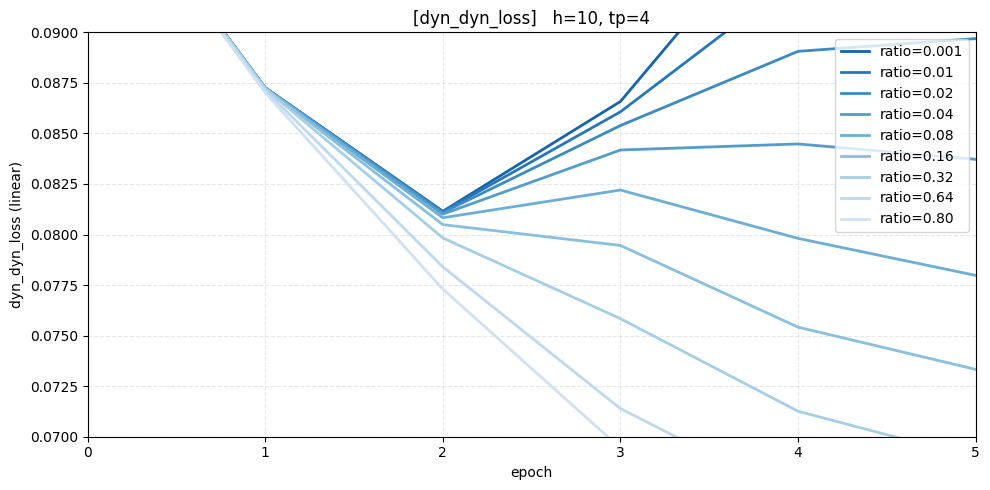

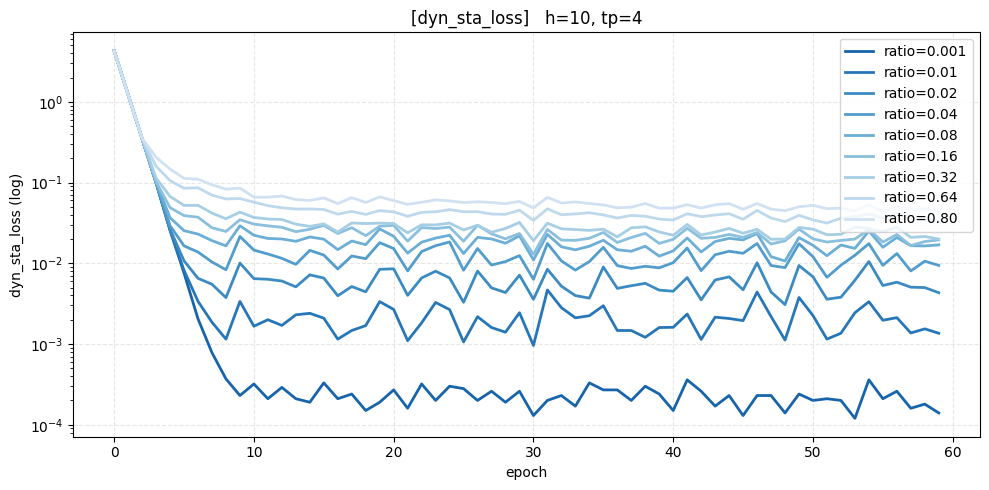

In [62]:
import re
import matplotlib.pyplot as plt
import numpy as np
import os

# ------------------------------------------------------------
# 正则表达式（与参考代码一致）
# ------------------------------------------------------------
re_epoch = re.compile(
    r"epoch\s+(\d+)\s+summary:\s*"
    r"dyn_dyn_loss\s*:\s*([\d\.Ee+-]+),\s*"
    r"dyn_sta_loss\s*:\s*([\d\.Ee+-]+),\s*"
    r"tot_dyn_loss\s*:\s*([\d\.Ee+-]+),"
)

# ------------------------------------------------------------
# 解析一个 log，提取 dyn_dyn_loss / dyn_sta_loss
# ------------------------------------------------------------
def extract_losses_from_log(path):
    dyn_dyn = []
    dyn_sta = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            m = re_epoch.search(line)
            if m:
                dyn_dyn.append(float(m.group(2)))
                dyn_sta.append(float(m.group(3)))
    return dyn_dyn, dyn_sta


# ------------------------------------------------------------
# 根据 h, tp, ratio 自动找到对应的 log 文件路径
# 新命名格式：ratio${ratio}_t${N_dynbr}_v${N_dynbr_v}_h${h}_tp${tp}.log
# 但本图要求：对每个 ratio 下，对所有 N_dynbr,N_dynbr_v 不取 max，
# 而是一张图只画每个 ratio 的一条曲线，因此需从磁盘中找对应文件。
#
# 你未指定 N_dynbr,N_dynbr_v，本函数将：
#   自动扫描 logs 下所有文件名，匹配 (h,tp,ratio) 的所有日志，
#   并选用其中 N_dynbr 和 N_dynbr_v 最小的那一份（保证唯一性）。
#
# 若你想改成最大或指定规则，我可以继续为你改写。
# ------------------------------------------------------------
def find_log_for(h, tp, ratio, N_dynbr, N_dynbr_v, log_root="."):
    """
    根据指定 h, tp, ratio, N_dynbr, N_dynbr_v 直接确定唯一日志文件。
    不再执行自动选择或排序。
    """
    target = f"ratio{ratio}_t{N_dynbr}_v{N_dynbr_v}_h{h}_tp{tp}.log"

    # 深度扫描 log_root 下所有目录，查找精确匹配的文件名
    for dp, _, fs in os.walk(log_root):
        for f in fs:
            if f == target:
                return os.path.join(dp, f)

    return None  # 未找到



def plot_dyn_losses_for(h, tp, ratio_list, N_dynbr, N_dynbr_v, log_root="."):
    cmap = plt.get_cmap("Blues_r")
    colors = [cmap(i) for i in np.linspace(0.2, 0.8, len(ratio_list))]

    # -----------------------------
    # 第一张图：dyn_dyn_loss（线性轴）
    # -----------------------------
    fig1, ax1 = plt.subplots(figsize=(10,5))

    for ratio, color in zip(ratio_list, colors):
        log_path = find_log_for(h, tp, ratio, N_dynbr, N_dynbr_v, log_root)
        if log_path is None:
            print(f"[WARN] 未找到对应日志：h={h}, tp={tp}, ratio={ratio}")
            continue
        
        print(f"[INFO] 读取日志：{log_path}")
        dyn_dyn, dyn_sta = extract_losses_from_log(log_path)
        epochs = np.arange(len(dyn_dyn))

        ax1.plot(epochs, dyn_dyn, color=color, linewidth=2, label=f"ratio={ratio}")

    ax1.set_xlabel("epoch")
    ax1.set_ylabel("dyn_dyn_loss (linear)")
    ax1.grid(True, linestyle="--", alpha=0.3)
    ax1.set_title(f"[dyn_dyn_loss]   h={h}, tp={tp}")
    ax1.legend(loc="upper right")
    ax1.set_xlim(0, 5)
    ax1.set_ylim(0.07, 0.09)
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # 第二张图：dyn_sta_loss（对数轴）
    # -----------------------------
    fig2, ax2 = plt.subplots(figsize=(10,5))

    for ratio, color in zip(ratio_list, colors):
        log_path = find_log_for(h, tp, ratio, N_dynbr, N_dynbr_v, log_root)
        if log_path is None:
            continue

        dyn_dyn, dyn_sta = extract_losses_from_log(log_path)
        epochs = np.arange(len(dyn_sta))

        ax2.plot(epochs, dyn_sta, color=color, linestyle="-", linewidth=2, label=f"ratio={ratio}")

    ax2.set_xlabel("epoch")
    ax2.set_ylabel("dyn_sta_loss (log)")
    ax2.set_yscale("log")
    ax2.grid(True, linestyle="--", alpha=0.3)
    ax2.set_title(f"[dyn_sta_loss]   h={h}, tp={tp}")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    
    plt.show()
    
    



# ------------------------------------------------------------
# 使用示例（你可以修改）
# ------------------------------------------------------------
h = 10
tp = 4
ratio_list = ["0.001", "0.01", "0.02", "0.04", "0.08", "0.16", "0.32", "0.64", "0.80"]
N_dynbr = 256

plot_dyn_losses_for(h, tp, ratio_list, N_dynbr, 4, log_root=".")